## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

In [1]:
#only for google colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/课程/CS231n/cs231n/assignment2")

In [0]:
!ls

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [0]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [0]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 9.54 and accuracy of 0.17
Trainable variables:    4
Iteration 100: with minibatch training loss = 0.963 and accuracy of 0.27
Trainable variables:    4
Iteration 200: with minibatch training loss = 0.883 and accuracy of 0.33
Trainable variables:    4
Iteration 300: with minibatch training loss = 0.693 and accuracy of 0.25
Trainable variables:    4
Iteration 400: with minibatch training loss = 0.623 and accuracy of 0.33
Trainable variables:    4
Iteration 500: with minibatch training loss = 0.54 and accuracy of 0.28
Trainable variables:    4
Iteration 600: with minibatch training loss = 0.52 and accuracy of 0.33
Trainable variables:    4
Iteration 700: with minibatch training loss = 0.434 and accuracy of 0.38
Trainable variables:    4
Epoch 1, Overall loss = 0.761 and accuracy of 0.308


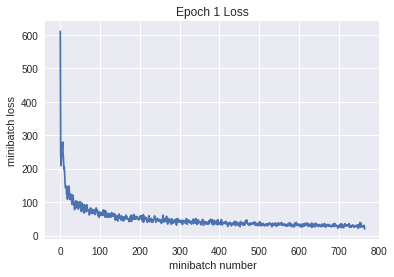

Validation
Epoch 1, Overall loss = 0.455 and accuracy of 0.36


In [7]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                print("Trainable variables: %4d"%(len(tf.trainable_variables())))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [0]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool) #tf.bool表明未来is_traning填充的是tf.bool类型的数据

Wconv1 = tf.get_variable("Wconv1", shape=[7,7,3,32])
bconv1 = tf.get_variable("bconv1", shape=[32])
W1 = tf.get_variable("W1", shape=[5408,1024])
b1 = tf.get_variable("b1", shape=[1024])
W2 = tf.get_variable("W2", shape=[1024, 10])
b2 = tf.get_variable("b2", shape=[10])
# define model
def complex_model(X,y,is_training):
    conv_out = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    rl1_out = tf.nn.relu(conv_out)
    bn_out = tf.contrib.layers.batch_norm(rl1_out, center=True, scale=True, is_training=True)
    pool_out = tf.nn.max_pool(bn_out, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pool_flat = tf.reshape(pool_out, [-1, 5408])
    aff_out = tf.matmul(pool_flat, W1) + b1
    rl2_out = tf.nn.relu(aff_out)
    out = tf.matmul(rl2_out, W2) + b2
    return out
    
y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [0]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 4.15 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [0]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 2.94 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [0]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None

total_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=(tf.one_hot(y,10)), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(1e-3)

In [0]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [0]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.11 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.63 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.59 and accuracy of 0.56
Iteration 300: with minibatch training loss = 1.26 and accuracy of 0.64
Iteration 400: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 500: with minibatch training loss = 1.3 and accuracy of 0.55
Iteration 600: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.59
Epoch 1, Overall loss = 1.67 and accuracy of 0.453


(1.6666556156898031, 0.4531428571428571)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [0]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.27 and accuracy of 0.537


(1.2713721914291383, 0.537)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [0]:
# Feel free to play with this cell

#approach1 not very good
def my_model(X,y,is_training):
    #{}conv=>bn=>relu=>pool} * 2 => aff=>bn=>=>relu=>aff
    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    bn1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
    re1 = tf.nn.relu(bn1)
    pool1 = tf.nn.max_pool(re1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    conv2 = tf.nn.conv2d(pool1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    bn2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
    re2 = tf.nn.relu(bn2)
    pool2 = tf.nn.max_pool(re2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    aff1 = tf.matmul(tf.reshape(pool2, (-1, 4096)), W1) + b1
    bn3 = tf.layers.batch_normalization(aff1, center=True, scale=True, training=is_training)
    re3 = tf.nn.relu(bn3)
    out = tf.matmul(re3, W2) + b2
    return out
    

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

global_step = tf.Variable(0)
#filter:[height, weight, in_chan, out_chan(num_filter)]
Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
bconv1 = tf.get_variable("bconv1", shape=[32])
Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
bconv2 = tf.get_variable("bconv2", shape=[64])

W1 = tf.get_variable("W1", shape=[4096, 1024])
b1 = tf.get_variable("b1", shape=[1024])
W2 = tf.get_variable("W2", shape=[1024, 10])
b2 = tf.get_variable("b2", shape=[10])

y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=y_out))
mean_loss += 0.002 * (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

learning_rate = tf.train.exponential_decay(0.001, global_step, 100, 0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 4.55 and accuracy of 0.094
Iteration 500: with minibatch training loss = 1.7 and accuracy of 0.58
Epoch 1, Overall loss = 2.07 and accuracy of 0.57


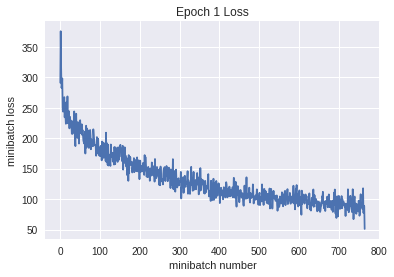

Iteration 1000: with minibatch training loss = 1.49 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 1.32 and accuracy of 0.73
Epoch 2, Overall loss = 1.34 and accuracy of 0.668


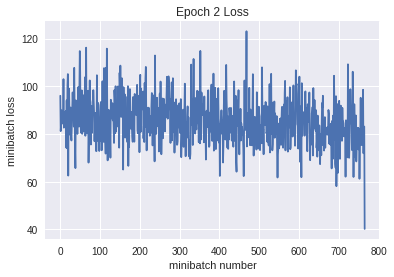

Iteration 2000: with minibatch training loss = 1.84 and accuracy of 0.53
Epoch 3, Overall loss = 1.27 and accuracy of 0.697


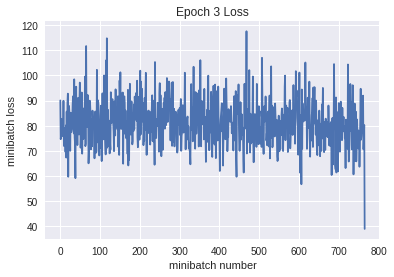

Iteration 2500: with minibatch training loss = 1.16 and accuracy of 0.72
Iteration 3000: with minibatch training loss = 1.16 and accuracy of 0.72
Epoch 4, Overall loss = 1.23 and accuracy of 0.716


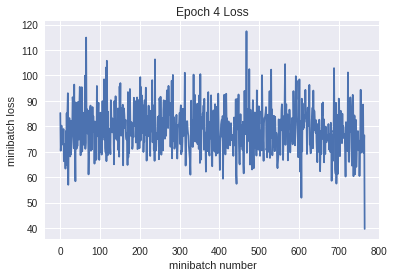

Iteration 3500: with minibatch training loss = 1.17 and accuracy of 0.78
Epoch 5, Overall loss = 1.18 and accuracy of 0.738


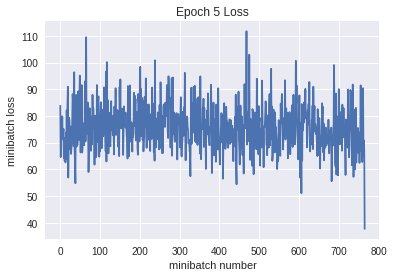

Iteration 4000: with minibatch training loss = 1.43 and accuracy of 0.69
Iteration 4500: with minibatch training loss = 1.15 and accuracy of 0.78
Epoch 6, Overall loss = 1.14 and accuracy of 0.757


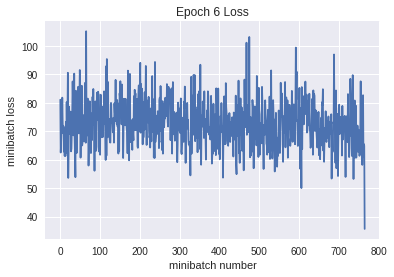

Iteration 5000: with minibatch training loss = 1.12 and accuracy of 0.73
Epoch 7, Overall loss = 1.09 and accuracy of 0.777


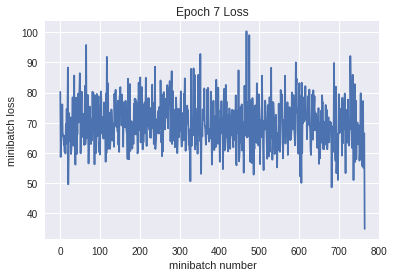

Iteration 5500: with minibatch training loss = 1.11 and accuracy of 0.83
Iteration 6000: with minibatch training loss = 1.1 and accuracy of 0.8
Epoch 8, Overall loss = 1.05 and accuracy of 0.795


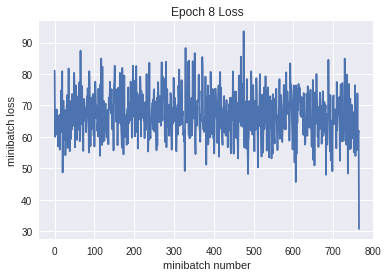

Iteration 6500: with minibatch training loss = 1.2 and accuracy of 0.7
Epoch 9, Overall loss = 1.01 and accuracy of 0.812


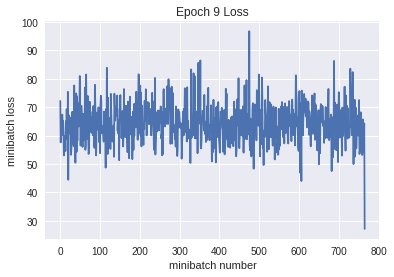

Iteration 7000: with minibatch training loss = 0.955 and accuracy of 0.83
Iteration 7500: with minibatch training loss = 0.669 and accuracy of 1
Epoch 10, Overall loss = 0.974 and accuracy of 0.824


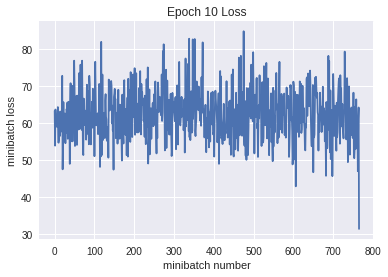

Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.722


(1.3689567260742188, 0.722)

In [0]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,500,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [0]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 1.02 and accuracy of 0.815
Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.722


(1.3689567050933837, 0.722)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

In [0]:
# Feel free to play with this cell

#approach2  well

def conv33_relu_batch(inputs, num_filter, is_training):
  #conv1=>relu=>bn=>dp =>conv2=>relu=>bn=>pool=>dp
  regularizer = tf.contrib.layers.l2_regularizer(scale=0.2)
  conv1 = tf.layers.conv2d(inputs=inputs, filters=num_filter, strides=[1,1], kernel_size=[3,3], padding='same', kernel_regularizer=regularizer)
  relu1 = tf.nn.relu6(conv1)
  bn1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=is_training)
  dp1 = tf.layers.dropout(inputs=bn1, rate=0.5)
  conv2 = tf.layers.conv2d(inputs=dp1, filters=num_filter*2, strides=[1,1], kernel_size=[3,3], padding='same', kernel_regularizer=regularizer)
  relu2 = tf.nn.relu6(conv2)
  bn2 = tf.layers.batch_normalization(relu2, center=True, scale=True, training=is_training)
  pool = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2,2], strides=2)
  dp2 = tf.layers.dropout(inputs=pool, rate=0.5)
  return dp2

def my_model(X,y,is_training):
    #[conv-relu-conv-relu] -> global average poolong -> softmax
    num_classes = 10
    nn1 = conv33_relu_batch(X, 64, is_training)
    nn2 = conv33_relu_batch(nn1, 128, is_training)
    nn3 = conv33_relu_batch(nn2, 256, is_training)
    #global average pooling
    pool_size = (nn3.shape[1], nn3.shape[2])
    pool_ave = tf.layers.average_pooling2d(
      inputs=nn3,
      pool_size=pool_size,
      strides=[1,1],
      padding='valid',
    data_format='channels_last')
    pool_ave_flat_size = pool_ave.shape[1] * pool_ave.shape[2] * pool_ave.shape[3]
    pool_ave_flat = tf.reshape(pool_ave, [-1, pool_ave_flat_size])
    dp = tf.layers.dropout(inputs=pool_ave_flat, rate=0.5, training=is_training)
    
    y_out = tf.layers.dense(inputs=dp, units=num_classes)
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)



y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=y_out))

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.001, global_step, 50, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 3.76 and accuracy of 0.11
Iteration 500: with minibatch training loss = 1.23 and accuracy of 0.58
Epoch 1, Overall loss = 1.43 and accuracy of 0.506


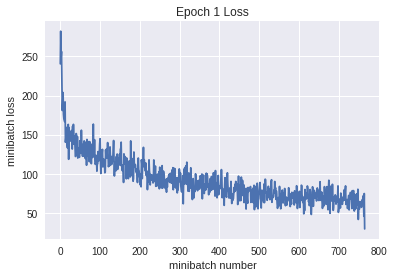

Iteration 1000: with minibatch training loss = 0.8 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.969 and accuracy of 0.67
Epoch 2, Overall loss = 0.853 and accuracy of 0.701


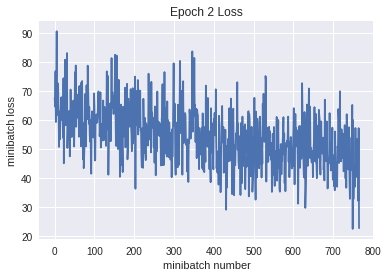

Iteration 2000: with minibatch training loss = 0.704 and accuracy of 0.73
Epoch 3, Overall loss = 0.66 and accuracy of 0.771


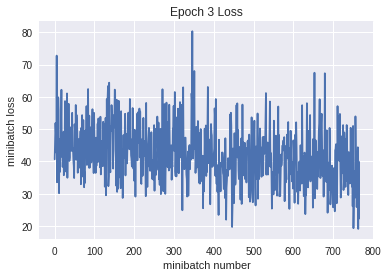

Iteration 2500: with minibatch training loss = 0.601 and accuracy of 0.75
Iteration 3000: with minibatch training loss = 0.517 and accuracy of 0.78
Epoch 4, Overall loss = 0.553 and accuracy of 0.808


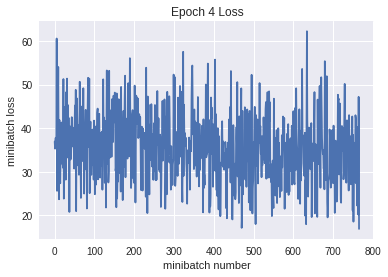

Iteration 3500: with minibatch training loss = 0.502 and accuracy of 0.83
Epoch 5, Overall loss = 0.469 and accuracy of 0.838


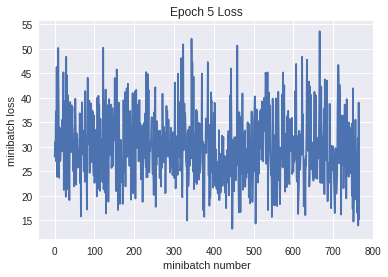

Iteration 4000: with minibatch training loss = 0.398 and accuracy of 0.84
Iteration 4500: with minibatch training loss = 0.642 and accuracy of 0.78
Epoch 6, Overall loss = 0.408 and accuracy of 0.859


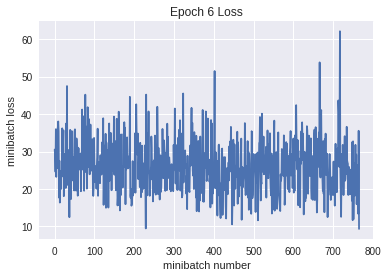

Iteration 5000: with minibatch training loss = 0.191 and accuracy of 0.92
Epoch 7, Overall loss = 0.356 and accuracy of 0.876


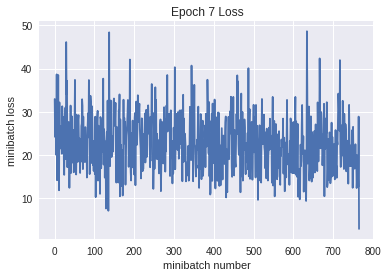

Iteration 5500: with minibatch training loss = 0.247 and accuracy of 0.94
Iteration 6000: with minibatch training loss = 0.302 and accuracy of 0.92
Epoch 8, Overall loss = 0.317 and accuracy of 0.89


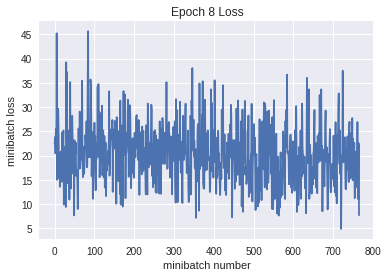

Iteration 6500: with minibatch training loss = 0.362 and accuracy of 0.88
Epoch 9, Overall loss = 0.278 and accuracy of 0.902


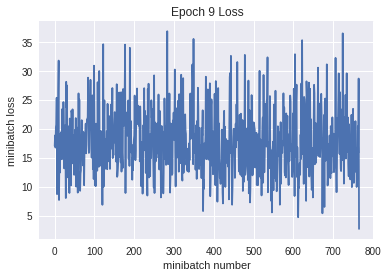

Iteration 7000: with minibatch training loss = 0.267 and accuracy of 0.88
Iteration 7500: with minibatch training loss = 0.394 and accuracy of 0.91
Epoch 10, Overall loss = 0.259 and accuracy of 0.908


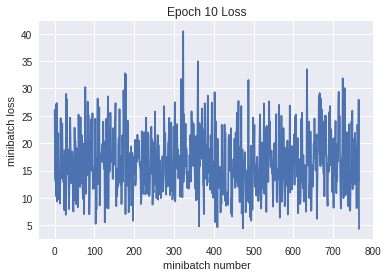

Validation
Epoch 1, Overall loss = 0.672 and accuracy of 0.801
Training
Epoch 1, Overall loss = 0.28 and accuracy of 0.9
Validation
Epoch 1, Overall loss = 0.672 and accuracy of 0.801


(0.6715510063171387, 0.801)

In [0]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,500,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

_Tell us here_

In [0]:
#approach3 resnet-50 #好慢- -
#下面的conv2d都忘记加正则化了- -
#在训练集准确率达到92%，然而验证集和测试集都80%左右，过拟合了。

def resnet_block_v2(inputs, depth, depth_bottleneck, stride, istraining=None):
#   ```
#   功能：获得一个bottleneck
#   shortcut结构：
#       1、在同一个stage之内
#           shortcut = input
#       2、在不同stage之间
#           shortcut = conv + bn
#     bottleneck结构：
#         input=>bn+relu=>conv1+stride1=>conv2+stride 2=>conv3+stride 1(先试试这个，然后再试试在conv1 2之后接bn+relu的效果)
#         1*1,64=>3*3,64=>1*1,256
#     fina:
#       out = shortcut+output
#   注意：1、到时应该要在最外层循环包装好stage和每个块的scope，以防止冲突！
#         2、两个stage交替之间，下一个stage的第一个块会进行一次stride为2的下采样，其余时候不需要
#         3、一个stage表示num_filters相同的不同块组成的集合。
#         4、默认假设是只有两个stage之间的第一个bottleneck为2，其余stage内部stride皆为1，
#   inputs:
#     inputs - inputs data,[N, H, W, C]
#     depth - bottleneck最后一层的输出维数
#     depth_bottleneck - bottleneck前两层的输出维数
#     stride - bottleneck中间卷积层的步长
#     training - 给batchnorm的参数
#   return:
#     outputs - bottleneck的输出
#   ```
  #判断是同一stage的块，还是不同stage之间的块
  if inputs.shape[3] == depth:
    shortcut = inputs
  else:
    shortcut = tf.layers.conv2d(inputs, depth, (1,1), 
                                strides=(stride, stride), 
                                name='conv-upSample', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
    shortcut = tf.layers.batch_normalization(shortcut, axis=3, name='bn-upSample',
                                            training=istraining, reuse=tf.AUTO_REUSE)
 
  residual = tf.layers.batch_normalization(inputs, axis=3, name='bn1', 
                                         training=istraining,reuse=tf.AUTO_REUSE)
  residual =  tf.nn.relu(residual)
  
  residual = tf.layers.conv2d(residual, depth_bottleneck, (1,1), 
                                strides=(1,1), 
                                name='conv1', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
  residual = tf.layers.conv2d(residual, depth_bottleneck, (3,3), 
                                strides=(stride, stride), 
                                name='conv2', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
  residual = tf.layers.conv2d(residual, depth, (1,1), 
                                strides=(1,1), 
                                name='conv3', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
  outputs = tf.add(residual, shortcut)
  return outputs

#resnet-34
def resnet_block_v1(inputs, num_filter, stride, istraining=None):
#   ```
#   功能：获得一个bottleneck
#   shortcut结构：
#       1、在同一个stage之内
#           shortcut = input
#       2、在不同stage之间
#           shortcut = conv + bn
#     bottleneck结构：
#         input=>bn+relu=>conv1 3*3 num_filter=>bn+relu=>conv2 3*3 num_filter
#         3*3 64=>3*3 64
#     final:
#       out = shortcut+output
#   注意：1、到时应该要在最外层循环包装好stage和每个块的scope，以防止冲突！
#         2、两个stage交替之间，下一个stage的第一个块会进行一次stride为2的下采样，其余时候不需要
#         3、一个stage表示num_filters相同的不同块组成的集合。
#         4、默认假设是只有两个stage之间的第一个bottleneck为2，其余stage内部stride皆为1，
#   inputs:
#     inputs - inputs data,[N, H, W, C]
#     num_filters - 滤波器维数
#     stride - 步长
#     training - 给batchnorm的参数
#   return:
#     outputs - bottleneck的输出
#   ```
  shortcut = inputs
  preact = tf.layers.batch_normalization(inputs, axis=3, name='bn-common', training=istraining, reuse=tf.AUTO_REUSE)
  preact = tf.nn.relu(preact)
  #判断是同一stage的块，还是不同stage之间的块
  if inputs.shape[3] != num_filter:
    shortcut = tf.layers.conv2d(preact, num_filter, (1,1), 
                                strides=(stride, stride), 
                                name='conv-upSample', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
    shortcut = tf.layers.batch_normalization(shortcut, axis=3, name='bn-upSample',
                                            training=istraining, reuse=tf.AUTO_REUSE)
  residual = tf.layers.conv2d(preact, num_filter, (3, 3), 
                              strides=(stride, stride), 
                              name='conv1', 
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                             reuse=tf.AUTO_REUSE,padding='same',
                             data_format='channels_last')
  residual = tf.layers.batch_normalization(residual, axis=3, name='bn1', 
                                         training=istraining,reuse=tf.AUTO_REUSE)
  residual =  tf.nn.relu(residual)
  

  residual = tf.layers.conv2d(residual, num_filter, (3,3), 
                                strides=(1, 1), 
                                name='conv2', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')

  outputs = tf.add(residual, shortcut)
  return outputs

def myresnet(inputs, is_training=None, num_classes=10, blocks=[(64,3), (128,4), (256,6), (512,3)]):
#   ```
#   功能：返回一个resnet-50的图
#   input:
#     inputs - 输入数据(N,H,W,C)
#     num_classes - 输出的类别
#     blocks - 一个列表，列表长度等于stage的数量，每一个元素为元组(baseFilter, num_bottleneck)，
#               记录了这个stage的基础滤波器数量和这个stage的块的数量，
#               每一个bottleneck组成为(1*1, baseFiler), （3*3， baseFilter）, (1*1, baseFilter*4)
#     is_training - 给batch_normalize的参数
#  output:
#     net - 生成的图
#   ```

  #对于我们的数据集输入channel为3，输出channel为16
  net = tf.layers.conv2d(inputs, filters=16, kernel_size=(3,3), strides=(1,1), name='first_conv',
                        reuse=tf.AUTO_REUSE, padding='same', data_format='channels_last')
  num_stage = len(blocks)
  for i in range(num_stage):
    with tf.variable_scope("stage_%d"%(i+1)):
      baseFilter, num_block = blocks[i]
      for j in range(num_block):
        stride = 1
        if(i>0 and j==0):
          stride = 2
        with tf.variable_scope("block_%d"%(j+1)):
          #net = resnet_block_v2(net, baseFilter*4, baseFilter, stride, istraining=is_training)
          net = resnet_block_v1(net, baseFilter, stride, istraining=is_training)
  #全局池化
  net = tf.reduce_mean(net, axis=[1,2], keepdims=True)
  net = tf.reshape(net, (-1, blocks[-1][0]))#如果是调用v2，则这里应该是(-1, blocks[-1][0]*4)，因为resnet50最后一层输出是baseFilter*4
  output = tf.layers.dense(net, units=num_classes, name='dense1', reuse=tf.AUTO_REUSE)
  return output

In [0]:
# Feel free to play with this cell
def my_model(X,y,is_training):
    out = myresnet(X, is_training)
    return out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=y_out))

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.001, global_step, 50, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.79 and accuracy of 0.16
Trainable variables:  149
Iteration 500: with minibatch training loss = 1.7 and accuracy of 0.36
Trainable variables:  149
Epoch 1, Overall loss = 1.97 and accuracy of 0.39


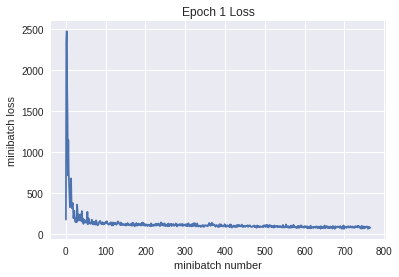

Iteration 1000: with minibatch training loss = 1.22 and accuracy of 0.55
Trainable variables:  149
Iteration 1500: with minibatch training loss = 1.29 and accuracy of 0.53
Trainable variables:  149
Epoch 2, Overall loss = 1.18 and accuracy of 0.584


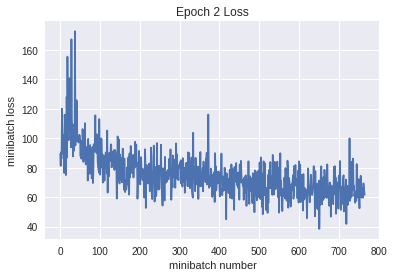

Iteration 2000: with minibatch training loss = 0.754 and accuracy of 0.72
Trainable variables:  149
Epoch 3, Overall loss = 0.935 and accuracy of 0.673


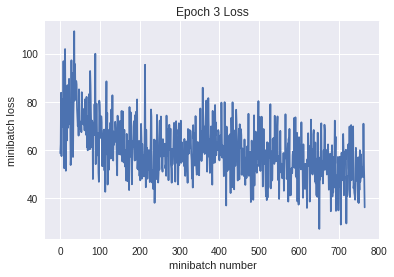

Iteration 2500: with minibatch training loss = 0.695 and accuracy of 0.77
Trainable variables:  149
Iteration 3000: with minibatch training loss = 0.701 and accuracy of 0.8
Trainable variables:  149
Epoch 4, Overall loss = 0.789 and accuracy of 0.728


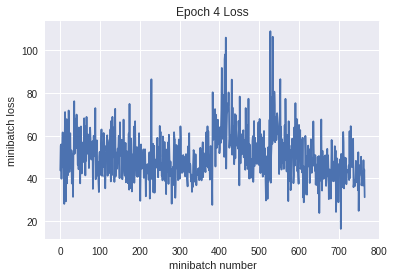

Iteration 3500: with minibatch training loss = 0.642 and accuracy of 0.8
Trainable variables:  149
Epoch 5, Overall loss = 0.607 and accuracy of 0.791


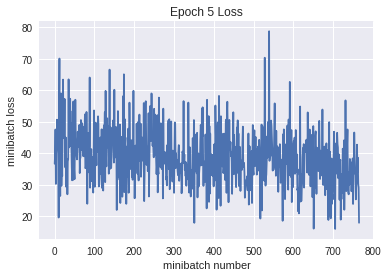

Iteration 4000: with minibatch training loss = 0.286 and accuracy of 0.91
Trainable variables:  149
Iteration 4500: with minibatch training loss = 0.531 and accuracy of 0.77
Trainable variables:  149
Epoch 6, Overall loss = 0.499 and accuracy of 0.829


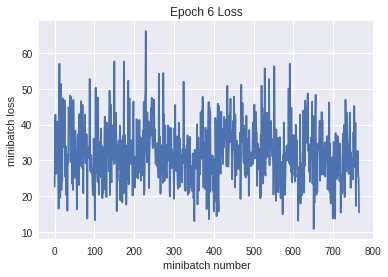

Iteration 5000: with minibatch training loss = 0.525 and accuracy of 0.8
Trainable variables:  149
Epoch 7, Overall loss = 0.405 and accuracy of 0.86


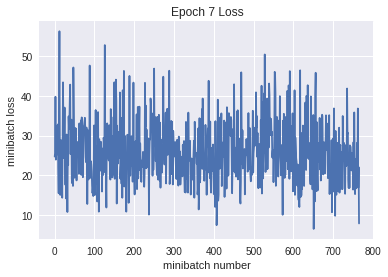

Iteration 5500: with minibatch training loss = 0.517 and accuracy of 0.86
Trainable variables:  149
Iteration 6000: with minibatch training loss = 0.38 and accuracy of 0.88
Trainable variables:  149
Epoch 8, Overall loss = 0.342 and accuracy of 0.883


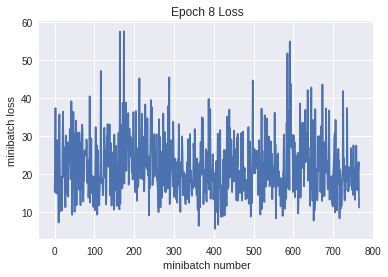

Iteration 6500: with minibatch training loss = 0.31 and accuracy of 0.91
Trainable variables:  149
Epoch 9, Overall loss = 0.276 and accuracy of 0.905


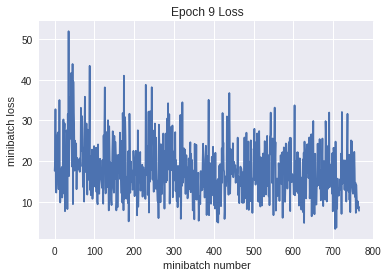

Iteration 7000: with minibatch training loss = 0.216 and accuracy of 0.92
Trainable variables:  149
Iteration 7500: with minibatch training loss = 0.16 and accuracy of 0.92
Trainable variables:  149
Epoch 10, Overall loss = 0.212 and accuracy of 0.927


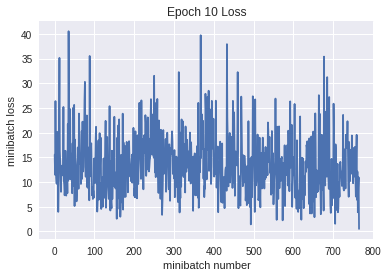

Validation
Epoch 1, Overall loss = 1.01 and accuracy of 0.789
Training
Epoch 1, Overall loss = 0.537 and accuracy of 0.885
Validation
Epoch 1, Overall loss = 1.01 and accuracy of 0.789


(1.0089498109817505, 0.789)

In [0]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,500,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [0]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.13 and accuracy of 0.781


(1.1259343191146851, 0.781)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


In [0]:
for j in tf.trainable_variables():
  print(j.name)

first_conv/kernel:0
first_conv/bias:0
stage_1/block_1/bn-common/gamma:0
stage_1/block_1/bn-common/beta:0
stage_1/block_1/conv-upSample/kernel:0
stage_1/block_1/conv-upSample/bias:0
stage_1/block_1/bn-upSample/gamma:0
stage_1/block_1/bn-upSample/beta:0
stage_1/block_1/conv1/kernel:0
stage_1/block_1/conv1/bias:0
stage_1/block_1/bn1/gamma:0
stage_1/block_1/bn1/beta:0
stage_1/block_1/conv2/kernel:0
stage_1/block_1/conv2/bias:0
stage_1/block_2/bn-common/gamma:0
stage_1/block_2/bn-common/beta:0
stage_1/block_2/conv1/kernel:0
stage_1/block_2/conv1/bias:0
stage_1/block_2/bn1/gamma:0
stage_1/block_2/bn1/beta:0
stage_1/block_2/conv2/kernel:0
stage_1/block_2/conv2/bias:0
stage_1/block_3/bn-common/gamma:0
stage_1/block_3/bn-common/beta:0
stage_1/block_3/conv1/kernel:0
stage_1/block_3/conv1/bias:0
stage_1/block_3/bn1/gamma:0
stage_1/block_3/bn1/beta:0
stage_1/block_3/conv2/kernel:0
stage_1/block_3/conv2/bias:0
stage_2/block_1/bn-common/gamma:0
stage_2/block_1/bn-common/beta:0
stage_2/block_1/conv-u

In [0]:
import tensorflow as tf

def foo(inputs):
  with tf.variable_scope("ha"):
    conv = tf.layers.conv2d(inputs, 5, (1,1), strides=1, name="conv",  data_format='channels_last')
    return conv
tf.reset_default_graph()
inputs = tf.random_normal([2,3,4,5])
print(inputs.shape[0])

with tf.Session() as sess:
  tf.global_variables_initializer().run()
  for i in range(3):
    with tf.variable_scope("here_%d"%i) as scope:
      a = foo(inputs)
      print(a.name)
  v = [j.name for j in tf.trainable_variables()]
  print(v)

2
here_0/ha/conv/BiasAdd:0
here_1/ha/conv/BiasAdd:0
here_2/ha/conv/BiasAdd:0
['here_0/ha/conv/kernel:0', 'here_0/ha/conv/bias:0', 'here_1/ha/conv/kernel:0', 'here_1/ha/conv/bias:0', 'here_2/ha/conv/kernel:0', 'here_2/ha/conv/bias:0']


In [0]:
#approach3 
#下面的conv2d都忘记加正则化了- -
#resnet-18 效果最好就是18了

def resnet_block_v1(inputs, num_filter, stride, istraining=None):
#   ```
#   功能：获得一个bottleneck
#   shortcut结构：
#       1、在同一个stage之内
#           shortcut = input
#       2、在不同stage之间
#           shortcut = conv + bn
#     bottleneck结构：
#         input=>bn+relu=>conv1 3*3 num_filter=>bn+relu=>conv2 3*3 num_filter
#         3*3 64=>3*3 64
#     final:
#       out = shortcut+output
#   注意：1、到时应该要在最外层循环包装好stage和每个块的scope，以防止冲突！
#         2、两个stage交替之间，下一个stage的第一个块会进行一次stride为2的下采样，其余时候不需要
#         3、一个stage表示num_filters相同的不同块组成的集合。
#         4、默认假设是只有两个stage之间的第一个bottleneck为2，其余stage内部stride皆为1，
#   inputs:
#     inputs - inputs data,[N, H, W, C]
#     num_filters - 滤波器维数
#     stride - 步长
#     training - 给batchnorm的参数
#   return:
#     outputs - bottleneck的输出
#   ```
# regularizer = tf.contrib.layers.l2_regularizer(scale=0.2)
#   conv1 = tf.layers.conv2d(inputs=inputs, filters=num_filter, strides=[1,1], kernel_size=[3,3], padding='same', kernel_regularizer=regularizer)
  shortcut = inputs
  #判断是同一stage的块，还是不同stage之间的块
  if inputs.shape[3] != num_filter:
    shortcut = tf.layers.conv2d(shortcut, num_filter, (1,1), 
                                strides=(stride, stride), 
                                name='conv-upSample', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
    shortcut = tf.layers.batch_normalization(shortcut, axis=3, name='bn-upSample',
                                            training=istraining, reuse=tf.AUTO_REUSE)
  residual = tf.layers.conv2d(inputs, num_filter, (3, 3), 
                              strides=(stride, stride), 
                              name='conv1', 
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                             reuse=tf.AUTO_REUSE,padding='same',
                             data_format='channels_last')
  residual = tf.layers.batch_normalization(residual, axis=3, name='bn1', 
                                         training=istraining,reuse=tf.AUTO_REUSE)
  residual =  tf.nn.relu(residual)
  

  residual = tf.layers.conv2d(residual, num_filter, (3,3), 
                                strides=(1, 1), 
                                name='conv2', 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               reuse=tf.AUTO_REUSE,padding='same',
                               data_format='channels_last')
  residual = tf.layers.batch_normalization(residual, axis=3, name='bn2', 
                                          training=istraining, reuse=tf.AUTO_REUSE)

  outputs = tf.add(residual, shortcut)
  outputs = tf.nn.relu(outputs)
  return outputs

def myresnet(inputs, is_training=None, num_classes=10, blocks=[(64,2), (128,2), (256,2), (512,2)]):
#   ```
#   功能：返回一个resnet-18的图
#   input:
#     inputs - 输入数据(N,H,W,C)
#     num_classes - 输出的类别
#     blocks - 一个列表，列表长度等于stage的数量，每一个元素为元组(baseFilter, num_bottleneck)，
#               记录了这个stage的基础滤波器数量和这个stage的块的数量，
#               每一个bottleneck组成为(1*1, baseFiler), （3*3， baseFilter）, (1*1, baseFilter*4)
#     is_training - 给batch_normalize的参数
#  output:
#     net - 生成的图
#   ```

  #对于我们的数据集输入channel为3，输出channel为16
  net = tf.layers.conv2d(inputs, filters=16, kernel_size=(3,3), strides=(1,1), name='first_conv',
                        reuse=tf.AUTO_REUSE, padding='same', data_format='channels_last')
  num_stage = len(blocks)
  for i in range(num_stage):
    with tf.variable_scope("stage_%d"%(i+1)):
      baseFilter, num_block = blocks[i]
      for j in range(num_block):
        stride = 1
        if(i>0 and j==0):
          stride = 2
        with tf.variable_scope("block_%d"%(j+1)):
          #net = resnet_block_v2(net, baseFilter*4, baseFilter, stride, istraining=is_training)
          net = resnet_block_v1(net, baseFilter, stride, istraining=is_training)
  #全局池化
  net = tf.reduce_mean(net, axis=[1,2], keepdims=True)
  net = tf.reshape(net, (-1, blocks[-1][0]))#如果是调用v2，则这里应该是(-1, blocks[-1][0]*4)，因为resnet50最后一层输出是baseFilter*4
  output = tf.layers.dense(net, units=num_classes, name='dense1', reuse=tf.AUTO_REUSE)
  return output

In [0]:
# Feel free to play with this cell
def my_model(X,y,is_training):
    out = myresnet(X, is_training)
    return out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=y_out))

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.001, global_step, 50, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.61 and accuracy of 0.11
Trainable variables:   85
Iteration 500: with minibatch training loss = 1.05 and accuracy of 0.67
Trainable variables:   85
Epoch 1, Overall loss = 1.17 and accuracy of 0.583


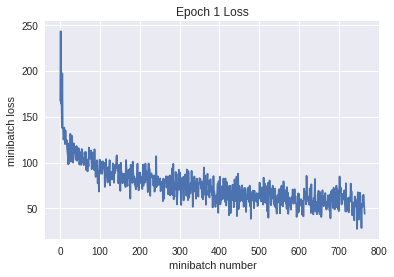

Iteration 1000: with minibatch training loss = 0.746 and accuracy of 0.66
Trainable variables:   85
Iteration 1500: with minibatch training loss = 0.514 and accuracy of 0.78
Trainable variables:   85
Epoch 2, Overall loss = 0.692 and accuracy of 0.759


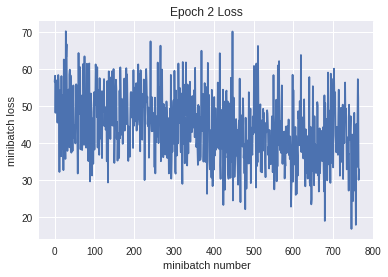

Iteration 2000: with minibatch training loss = 0.501 and accuracy of 0.81
Trainable variables:   85
Epoch 3, Overall loss = 0.5 and accuracy of 0.827


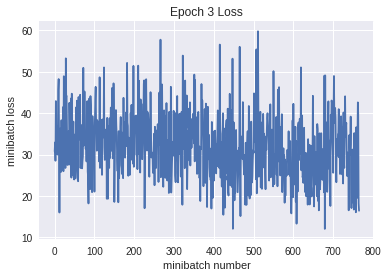

Iteration 2500: with minibatch training loss = 0.41 and accuracy of 0.91
Trainable variables:   85
Iteration 3000: with minibatch training loss = 0.629 and accuracy of 0.81
Trainable variables:   85
Epoch 4, Overall loss = 0.368 and accuracy of 0.873


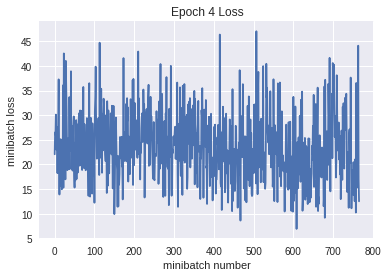

Iteration 3500: with minibatch training loss = 0.153 and accuracy of 0.94
Trainable variables:   85
Epoch 5, Overall loss = 0.27 and accuracy of 0.906


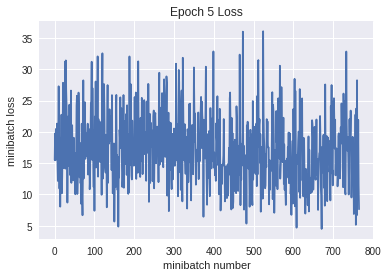

Iteration 4000: with minibatch training loss = 0.0828 and accuracy of 0.98
Trainable variables:   85
Iteration 4500: with minibatch training loss = 0.242 and accuracy of 0.94
Trainable variables:   85
Epoch 6, Overall loss = 0.189 and accuracy of 0.933


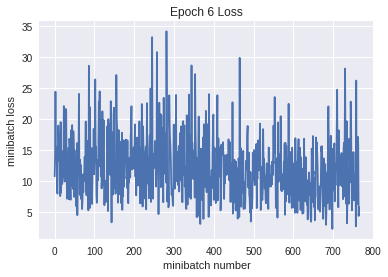

Iteration 5000: with minibatch training loss = 0.166 and accuracy of 0.92
Trainable variables:   85
Epoch 7, Overall loss = 0.139 and accuracy of 0.95


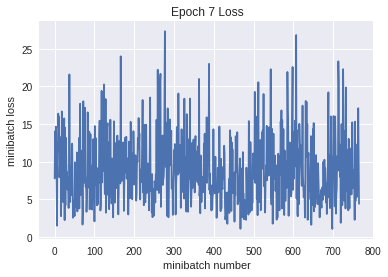

Iteration 5500: with minibatch training loss = 0.0806 and accuracy of 0.95
Trainable variables:   85
Iteration 6000: with minibatch training loss = 0.0921 and accuracy of 0.97
Trainable variables:   85
Epoch 8, Overall loss = 0.102 and accuracy of 0.964


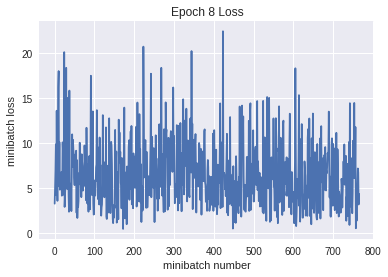

Iteration 6500: with minibatch training loss = 0.166 and accuracy of 0.95
Trainable variables:   85
Epoch 9, Overall loss = 0.0818 and accuracy of 0.971


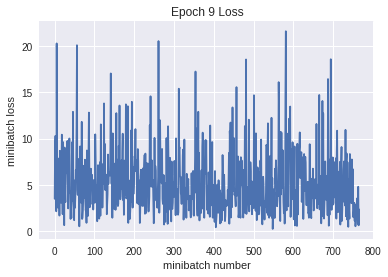

Iteration 7000: with minibatch training loss = 0.0188 and accuracy of 1
Trainable variables:   85
Iteration 7500: with minibatch training loss = 0.0318 and accuracy of 1
Trainable variables:   85
Epoch 10, Overall loss = 0.0714 and accuracy of 0.975


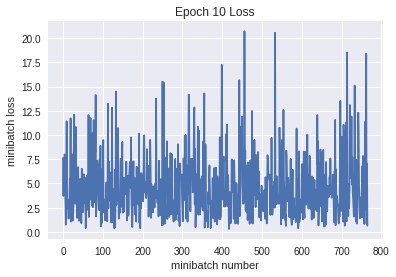

Validation
Epoch 1, Overall loss = 0.996 and accuracy of 0.797
Training
Epoch 1, Overall loss = 0.161 and accuracy of 0.949
Validation
Epoch 1, Overall loss = 0.996 and accuracy of 0.797


(0.9963096175193786, 0.797)

In [10]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,500,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.